# Notebook for Sleep Analysis of SWISC Output

#### This notebook provides code and examples for using SWISC output files to generate Pandas DataFrames containing rodent sleep analysis data in a useable format

#### Necessary import statements

In [1]:
import numpy as np
# import seaborn as sns
import matplotlib as mpl
from matplotlib.lines import Line2D
from datetime import datetime
import pandas as pd
import os
import glob
import config
from pathlib import Path
import multiprocessing as mp
from concurrent.futures import ProcessPoolExecutor
from time import gmtime, strftime
import config
import matplotlib.pyplot as plt

In [2]:
import sleep 

#### View all functions in sleep.py

In [3]:
dir(sleep)

['Line2D',
 'Path',
 'ProcessPoolExecutor',
 'ThreadPoolExecutor',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'average_bout_length_by_day',
 'average_bout_length_by_hour',
 'average_bout_length_by_week',
 'average_by_score',
 'bout_occurrences_by_day',
 'bout_occurrences_by_week',
 'compute_bout_occurrences',
 'compute_bouts',
 'config',
 'datetime',
 'getDatasetSummary',
 'get_condition_label',
 'get_time_label',
 'glob',
 'gmtime',
 'load_all_files',
 'mp',
 'mpl',
 'np',
 'os',
 'output_excel',
 'parse_file',
 'parse_file_optimized',
 'parse_start_times',
 'parse_start_times_fast',
 'partial',
 'pd',
 'process_all_data',
 'process_folder',
 'state_by_circadian',
 'state_by_day',
 'state_by_hour',
 'state_by_week',
 'strdtYMD',
 'strdtYMDH',
 'strftime']

#### Assign Data Folder Path (from config)

In [4]:
data_folder = config.scoring_output_path
print(data_folder)

D:/Pilocarpine/Export/ScoredData/


#### getDatasetSummary() acquires datasetSummary.xlsx from SWISC folder
    This .xlsx contains the following columns for each experimental animal:
        Name: Animal designation found in file names
        Start: Date ( on which the recordings to be processed started
        End: Date on which recordings to be processed ended
        Condition: Treatment conditions for animals if unblinded.  X in this column will lead to exclusion.
        Include: Leave blank to process.  X in this column will lead to exclusion.
            
        Pre-Condition Days: Days recorded before treatment
        Condition Start Date: Date of Condition change
        Condition Start Time: Time of Condition change
        Condition Start Datetime will be generated from these columns
            All scored epochs prior to Condition Start Datetime will be marked "Ante" treatment, all scored epochs after will be marked "Post" treatment
            "Ante" and "Post" are used due to alphebetical sorting of the "Prepost" column
        Post-Condition-Days: Currently unused

     

In [5]:
datasetSummary = sleep.getDatasetSummary()
datasetSummary.head(10)

,Name,Start,End,Condition,Include,Pre-Condition Days,Condition Start Date,Condition Start Time,Post-Condition-Days,Condition Start DateTime
0,NPM564,2019-10-03,2019-10-07,KA,NaN,0.0,2019-10-03,00:00:00,21.0,2019-10-03
1,NPM565,NaT,NaT,NaN,X,NaN,NaT,NaN,NaN,NaT
2,NPM566,2019-10-04,2019-10-23,KA,NaN,0.0,2019-10-04,00:00:00,21.0,2019-10-04
3,NPM567,2019-10-05,2019-10-24,KA,NaN,0.0,2019-10-05,00:00:00,21.0,2019-10-05
4,NPM568,2019-10-05,2019-10-14,KA,NaN,0.0,2019-10-05,00:00:00,21.0,2019-10-05
5,NPM569,2019-10-11,2019-10-30,NaCl,NaN,0.0,2019-10-11,00:00:00,21.0,2019-10-11
6,NPM570,2019-10-11,2019-10-30,NaCl,NaN,0.0,2019-10-11,00:00:00,21.0,2019-10-11
7,NPM571,2019-10-11,2019-10-30,NaCl,NaN,0.0,2019-10-11,00:00:00,21.0,2019-10-11
8,NPM572,2019-10-11,2019-10-30,NaCl,NaN,0.0,2019-10-11,00:00:00,21.0,2019-10-11
9,NPM574,2020-01-03,2020-01-31,Sal,NaN,7.0,2020-01-10,00:00:00,21.0,2020-01-10


Load some data

In [7]:
# Create empty DataFrame
subjectwise_df=pd.DataFrame()

# Iterate over animal folders in Processed Data folder 
# for folder in os.listdir(data_folder)[:]:
    # Get all .csv files in subfolder
all_files = glob.glob(os.path.join(data_folder, '*.csv'))

"""

Parse file according to parse_file_optimized for metadata and scores
Assigns all sleep scored epochs to timestamps relative to the start time in the input file's name
Concatenates and orders all files for each animal

"""

df_list = [sleep.parse_file_optimized(file, config) for file in all_files]
combined_df = pd.concat(df_list, ignore_index=True)

subjectwise_df=pd.concat([subjectwise_df,combined_df], ignore_index=True)
display(f'post folder: {strftime("%a, %d %b %Y %H:%M:%S +0000", gmtime())}')


subjectwise_df['year'] = subjectwise_df['datetime'].dt.year
subjectwise_df['month'] = subjectwise_df['datetime'].dt.month
subjectwise_df['day'] = subjectwise_df['datetime'].dt.day
subjectwise_df['hour'] = subjectwise_df['datetime'].dt.hour

df=sleep.parse_start_times_fast(subjectwise_df,datasetSummary)
df=df[(df['condition']!='X') & (df['include']!='X') & (df['recorded']!='Ante')]

display(f'post parse: {strftime("%a, %d %b %Y %H:%M:%S +0000", gmtime())}')

'post folder: Fri, 31 Jan 2025 18:46:03 +0000'

'post parse: Fri, 31 Jan 2025 18:46:46 +0000'

#### Assess first few entries DataFrame
##### Each row contains a timestamped epoch along with its sleep score

In [8]:
df.head(20)

,datetime,subject,scores,epoch_length,year,month,day,hour,prepost,recorded,condition,include
62663,2024-01-30 00:00:02,NPM727,0,0 days 00:00:04,2024,1,30,0,Ante,Post,NaCl,Include
62664,2024-01-30 00:00:06,NPM727,0,0 days 00:00:04,2024,1,30,0,Ante,Post,NaCl,Include
62665,2024-01-30 00:00:10,NPM727,0,0 days 00:00:04,2024,1,30,0,Ante,Post,NaCl,Include
62666,2024-01-30 00:00:14,NPM727,0,0 days 00:00:04,2024,1,30,0,Ante,Post,NaCl,Include
62667,2024-01-30 00:00:18,NPM727,0,0 days 00:00:04,2024,1,30,0,Ante,Post,NaCl,Include
62668,2024-01-30 00:00:22,NPM727,0,0 days 00:00:04,2024,1,30,0,Ante,Post,NaCl,Include
62669,2024-01-30 00:00:26,NPM727,0,0 days 00:00:04,2024,1,30,0,Ante,Post,NaCl,Include
62670,2024-01-30 00:00:30,NPM727,0,0 days 00:00:04,2024,1,30,0,Ante,Post,NaCl,Include
62671,2024-01-30 00:00:34,NPM727,0,0 days 00:00:04,2024,1,30,0,Ante,Post,NaCl,Include
62672,2024-01-30 00:00:38,NPM727,0,0 days 00:00:04,2024,1,30,0,Ante,Post,NaCl,Include


In [9]:
df['subject'][df['condition']=='Pilo'].unique()

array(['NPM732', 'NPM733', 'NPM734', 'NPM745', 'NPM749', 'NPM750',
       'NPM764', 'NPM766', 'NPM767'], dtype=object)

In [10]:
# 1. Compute total seconds per label per hour
circadian = sleep.state_by_circadian(df)

with pd.option_context('display.max_rows', 20, 'display.max_columns', 10):
    display(circadian.head(300))

seconds_per_bin  epochs  \
condition subject prepost scores hour                           
NaCl      NPM727  Ante    0      0    0 days 05:36:28       8   
                                 1    0 days 05:03:44       8   
                                 2    0 days 03:21:12       8   
                                 3    0 days 02:21:28       7   
                                 4    0 days 03:32:16       7   
...                                               ...     ...   
          NPM728  Post    0      4    0 days 06:24:20      15   
                                 5    0 days 07:43:32      15   
                                 6    0 days 07:54:16      14   
                                 7    0 days 07:49:36      15   
                                 8    0 days 06:19:52      15   

                                                 datetime  \
condition subject prepost scores hour                       
NaCl      NPM727  Ante    0      0    2024-01-30 00:00:02   
                                 1    2024-01-30 01:00:02   
                                 2    2024-01-30 02:00:02   
                                 3    2024-01-31 03:08:34   
                                 4    2024-01-31 04:00:02   
...                                                   ...   
          NPM728  Post    0      4    2024-02-07 04:01:40   
                                 5    2024-02-07 05:15:56   
                                 6    2024-02-07 06:00:40   
                                 7    2024-02-07 07:00:00   
                                 8    2024-02-07 08:00:01   

                                       mean_seconds_per_circadian_hour  
condition subject prepost scores hour                                   
NaCl      NPM727  Ante    0      0                         2523.500000  
                                 1                         2278.000000  
                                 2                         1509.000000  
                                 3                         1212.571429  
                                 4                         1819.428571  
...                                                                ...  
          NPM728  Post    0      4                         1537.333333  
                                 5                         1854.133333  
                                 6                         2032.571429  
                                 7                         1878.400000  
                                 8                         1519.466667  

[300 rows x 4 columns]

In [11]:
# 2a. Average by hour
hourly = sleep.state_by_hour(df)
display(hourly)

seconds_per_hour  \
condition subject prepost scores year month day hour                    
NaCl      NPM727  Ante    0      2024 1     30  0     0 days 00:52:52   
                                                1     0 days 00:57:04   
                                                2     0 days 00:18:52   
                                                7     0 days 00:37:56   
                                                8     0 days 00:20:32   
...                                                               ...   
Pilo      NPM767  Post    4      2024 7     23  0     0 days 00:00:32   
                                                2     0 days 00:00:12   
                                                3     0 days 00:01:36   
                                                5     0 days 00:00:04   
                                                6     0 days 00:00:40   

                                                                datetime  
condition subject prepost scores year month day hour                      
NaCl      NPM727  Ante    0      2024 1     30  0    2024-01-30 00:00:02  
                                                1    2024-01-30 01:00:02  
                                                2    2024-01-30 02:00:02  
                                                7    2024-01-30 07:00:24  
                                                8    2024-01-30 08:07:28  
...                                                                  ...  
Pilo      NPM767  Post    4      2024 7     23  0    2024-07-23 00:40:04  
                                                2    2024-07-23 02:47:08  
                                                3    2024-07-23 03:11:52  
                                                5    2024-07-23 05:32:00  
                                                6    2024-07-23 06:30:56  

[47611 rows x 2 columns]

In [12]:
# 3. Compute bout lengths and occurrences
bouts, by_bout_id = sleep.compute_bouts(df)
display(bouts)
display(by_bout_id)

,datetime,subject,scores,epoch_length,year,month,day,hour,prepost,recorded,condition,include,bout_id
62663,2024-01-30 00:00:02,NPM727,0,0 days 00:00:04,2024,1,30,0,Ante,Post,NaCl,Include,1
62664,2024-01-30 00:00:06,NPM727,0,0 days 00:00:04,2024,1,30,0,Ante,Post,NaCl,Include,1
62665,2024-01-30 00:00:10,NPM727,0,0 days 00:00:04,2024,1,30,0,Ante,Post,NaCl,Include,1
62666,2024-01-30 00:00:14,NPM727,0,0 days 00:00:04,2024,1,30,0,Ante,Post,NaCl,Include,1
62667,2024-01-30 00:00:18,NPM727,0,0 days 00:00:04,2024,1,30,0,Ante,Post,NaCl,Include,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15762391,2024-07-23 07:15:08,NPM767,1,0 days 00:00:04,2024,7,23,7,Post,Post,Pilo,Include,985645
15762392,2024-07-23 07:15:12,NPM767,1,0 days 00:00:04,2024,7,23,7,Post,Post,Pilo,Include,985645
15762393,2024-07-23 07:15:16,NPM767,1,0 days 00:00:04,2024,7,23,7,Post,Post,Pilo,Include,985645
15762394,2024-07-23 07:15:20,NPM767,1,0 days 00:00:04,2024,7,23,7,Post,Post,Pilo,Include,985645


bout_length  \
condition subject prepost bout_id scores year month day hour                   
NaCl      NPM727  Ante    1       0      2024 1     30  0    0 days 00:01:36   
                          2       1      2024 1     30  0    0 days 00:00:24   
                          3       0      2024 1     30  0    0 days 00:02:24   
                          4       1      2024 1     30  0    0 days 00:02:00   
                          5       2      2024 1     30  0    0 days 00:00:08   
...                                                                      ...   
Pilo      NPM767  Post    985641  2      2024 7     23  7    0 days 00:00:12   
                          985642  0      2024 7     23  7    0 days 00:00:04   
                          985643  1      2024 7     23  7    0 days 00:00:08   
                          985644  0      2024 7     23  7    0 days 00:06:28   
                          985645  1      2024 7     23  7    0 days 00:02:56   

                                                                        datetime  
condition subject prepost bout_id scores year month day hour                      
NaCl      NPM727  Ante    1       0      2024 1     30  0    2024-01-30 00:00:02  
                          2       1      2024 1     30  0    2024-01-30 00:01:38  
                          3       0      2024 1     30  0    2024-01-30 00:02:02  
                          4       1      2024 1     30  0    2024-01-30 00:04:26  
                          5       2      2024 1     30  0    2024-01-30 00:06:26  
...                                                                          ...  
Pilo      NPM767  Post    985641  2      2024 7     23  7    2024-07-23 07:05:40  
                          985642  0      2024 7     23  7    2024-07-23 07:05:52  
                          985643  1      2024 7     23  7    2024-07-23 07:05:56  
                          985644  0      2024 7     23  7    2024-07-23 07:06:04  
                          985645  1      2024 7     23  7    2024-07-23 07:12:32  

[998710 rows x 2 columns]

In [13]:
# 3a. Average bout length by state by day
average_bout_length_day = sleep.average_bout_length_by_day(by_bout_id)
display(average_bout_length_day)


average_bout_length  \
condition subject scores year month day                             
NaCl      NPM727  0      2024 1     30  0 days 00:02:08.197183098   
                                    31  0 days 00:02:08.467780429   
                              2     1   0 days 00:01:31.442561205   
                                    2   0 days 00:01:32.379928315   
                                    3   0 days 00:01:28.885245901   
...                                                           ...   
Pilo      NPM767  4      2024 7     19  0 days 00:00:13.806451612   
                                    20  0 days 00:00:08.888888888   
                                    21  0 days 00:00:08.756756756   
                                    22  0 days 00:00:11.090909090   
                                    23  0 days 00:00:15.333333333   

                                                   datetime  
condition subject scores year month day                      
NaCl      NPM727  0      2024 1     30  2024-01-30 00:00:02  
                                    31  2024-01-31 00:00:10  
                              2     1   2024-02-01 00:00:01  
                                    2   2024-02-02 00:00:00  
                                    3   2024-02-03 00:00:03  
...                                                     ...  
Pilo      NPM767  4      2024 7     19  2024-07-19 00:06:05  
                                    20  2024-07-20 00:31:16  
                                    21  2024-07-21 00:27:12  
                                    22  2024-07-22 00:29:13  
                                    23  2024-07-23 00:40:04  

[2776 rows x 2 columns]

In [14]:
# 3b. Average bout length by week
average_bout_length_by_week = sleep.average_bout_length_by_week(by_bout_id)
average_bout_length_by_week

average_bout_length  \
condition subject scores year month week                             
NaCl      NPM727  0      2024 1     5    0 days 00:02:08.358463726   
                              2     5    0 days 00:01:35.498207885   
                                    6    0 days 00:01:26.556390977   
                                    7    0 days 00:01:38.280649926   
                                    8    0 days 00:01:20.303232998   
...                                                            ...   
Pilo      NPM767  4      2024 6     26   0 days 00:00:07.723404255   
                              7     27   0 days 00:00:08.423963133   
                                    28   0 days 00:00:09.817073170   
                                    29   0 days 00:00:11.806896551   
                                    30             0 days 00:00:12   

                                                    datetime  
condition subject scores year month week                      
NaCl      NPM727  0      2024 1     5    2024-01-30 00:00:02  
                              2     5    2024-02-01 00:00:01  
                                    6    2024-02-05 00:00:03  
                                    7    2024-02-12 00:00:01  
                                    8    2024-02-19 00:00:31  
...                                                      ...  
Pilo      NPM767  4      2024 6     26   2024-06-24 00:03:55  
                              7     27   2024-07-01 03:33:50  
                                    28   2024-07-08 00:33:15  
                                    29   2024-07-15 02:12:17  
                                    30   2024-07-22 00:29:13  

[605 rows x 2 columns]

In [15]:
# 4a. Compute bout occurrences
bout_occurrences = sleep.bout_occurrences_by_day(bouts)
display(bout_occurrences)

bout_occurrences
condition subject prepost scores year month day                  
NaCl      NPM727  Ante    0      2024 1     30                273
                                            31                406
                                      2     1                 516
                                            2                 547
                                            3                 475
...                                                           ...
Pilo      NPM767  Post    4      2024 7     19                 93
                                            20                 27
                                            21                 37
                                            22                 43
                                            23                 12

[2840 rows x 1 columns]

In [16]:
# # 4b. Compute bout occurrences by week
average_bout_occurrences_weekly = sleep.bout_occurrences_by_week(bouts)
average_bout_occurrences_weekly

bout_occurrences
condition subject prepost scores year month week                  
NaCl      NPM727  Ante    0      2024 1     5                  679
                                      2     5                 1899
                                            6                  532
                          1      2024 1     5                  883
                                      2     5                 2975
...                                                            ...
Pilo      NPM767  Post    3      2024 7     30                   3
                          4      2024 7     27                 206
                                            28                 328
                                            29                 435
                                            30                  55

[684 rows x 1 columns]

# Save Data to Excel
#### Save data to Excel with output_excel function
#### sleep.output_excel(DataFrame['field'], filename)

In [183]:
output_df=state_by_hour(df)
sleep.output_excel(data=output_df['seconds_per_hour'], output_path='./', filename='StateSecondsByHour.xlsx')

In [ ]:
output_df=average_bout_length_by_hour(by_bout_id)
sleep.output_excel(data=output_df['average_bout_length'], output_path='./', filename='AvgBoutLengthByHour.xlsx')

In [184]:
output_df=average_bout_length_by_day(by_bout_id)
sleep.output_excel(data=output_df['average_bout_length'], output_path='./', filename='AvgBoutLengthByDay.xlsx')

#### Add the following to by_bout_id: 
#### .groupby('scores').getgroup(score).groupby('subject').get_group(animal) 
#### to calculate bout lengths for specific states and animals

In [ ]:
score=0
animal='NPM739'
grouped_score=by_bout_id.groupby('scores').get_group(score).groupby('subject').get_group(animal)
output=average_bout_length_by_hour(grouped_score)

In [225]:
NPM739A=df[(df['subject']=='NPM739') & (df['prepost']=='Post')]
NPM739A

,datetime,subject,scores,epoch_length,year,month,day,hour,prepost,recorded,condition,include,bout_id
159674,2024-03-18 16:36:02,NPM739,1,0 days 00:00:04,2024,3,18,16,Post,Post,KA,Include,9540
159675,2024-03-18 16:36:06,NPM739,1,0 days 00:00:04,2024,3,18,16,Post,Post,KA,Include,9540
159676,2024-03-18 16:36:10,NPM739,1,0 days 00:00:04,2024,3,18,16,Post,Post,KA,Include,9540
159677,2024-03-18 16:36:14,NPM739,0,0 days 00:00:04,2024,3,18,16,Post,Post,KA,Include,9541
159678,2024-03-18 16:36:18,NPM739,0,0 days 00:00:04,2024,3,18,16,Post,Post,KA,Include,9541
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1656758,2024-05-29 07:26:21,NPM739,0,0 days 00:00:04,2024,5,29,7,Post,Post,KA,Include,95112
1656759,2024-05-29 07:26:25,NPM739,0,0 days 00:00:04,2024,5,29,7,Post,Post,KA,Include,95112
1656760,2024-05-29 07:26:29,NPM739,0,0 days 00:00:04,2024,5,29,7,Post,Post,KA,Include,95112
1656761,2024-05-29 07:26:33,NPM739,0,0 days 00:00:04,2024,5,29,7,Post,Post,KA,Include,95112


In [ ]:
NPM739A=df[(df['subject']=='NPM739') & (df['prepost']=='Ante')]
NPM739P=df[(df['subject']=='NPM739') & (df['prepost']=='Post')]

NPM758A=df[(df['subject']=='NPM758') & (df['prepost']=='Ante')]
NPM758P=df[(df['subject']=='NPM758') & (df['prepost']=='Post')]


# output['seconds_per_hour']=output['seconds_per_hour'].astype('str')
outpath='Y:/SMRXConversion/Export/'

outfile='NPM739Pre.xlsx'
with pd.ExcelWriter(
    f'{outpath+outfile}',
    date_format="YYYY-MM-DD",
    datetime_format="YYYY-MM-DD HH:MM:SS") as writer:
    NPM739A.to_excel(writer)  

outfile='NPM739Post.xlsx'

with pd.ExcelWriter(
    f'{outpath+outfile}',
    date_format="YYYY-MM-DD",
    datetime_format="YYYY-MM-DD HH:MM:SS") as writer:
    NPM739P.to_excel(writer)  

outfile='NPM758Pre.xlsx'
with pd.ExcelWriter(
    f'{outpath+outfile}',
    date_format="YYYY-MM-DD",
    datetime_format="YYYY-MM-DD HH:MM:SS") as writer:
    NPM758A.to_excel(writer)  
outfile='NPM758Post.xlsx'
with pd.ExcelWriter(
    f'{outpath+outfile}',
    date_format="YYYY-MM-DD",
    datetime_format="YYYY-MM-DD HH:MM:SS") as writer:
    NPM758P.to_excel(writer)  

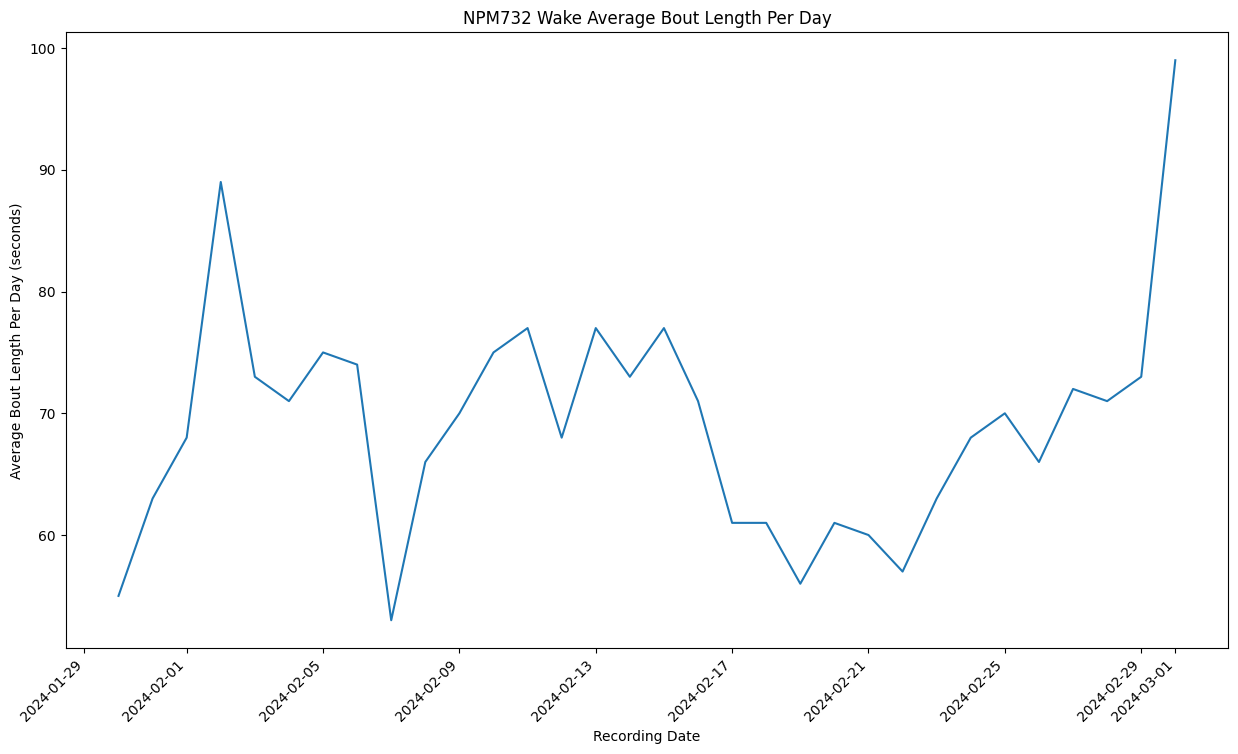

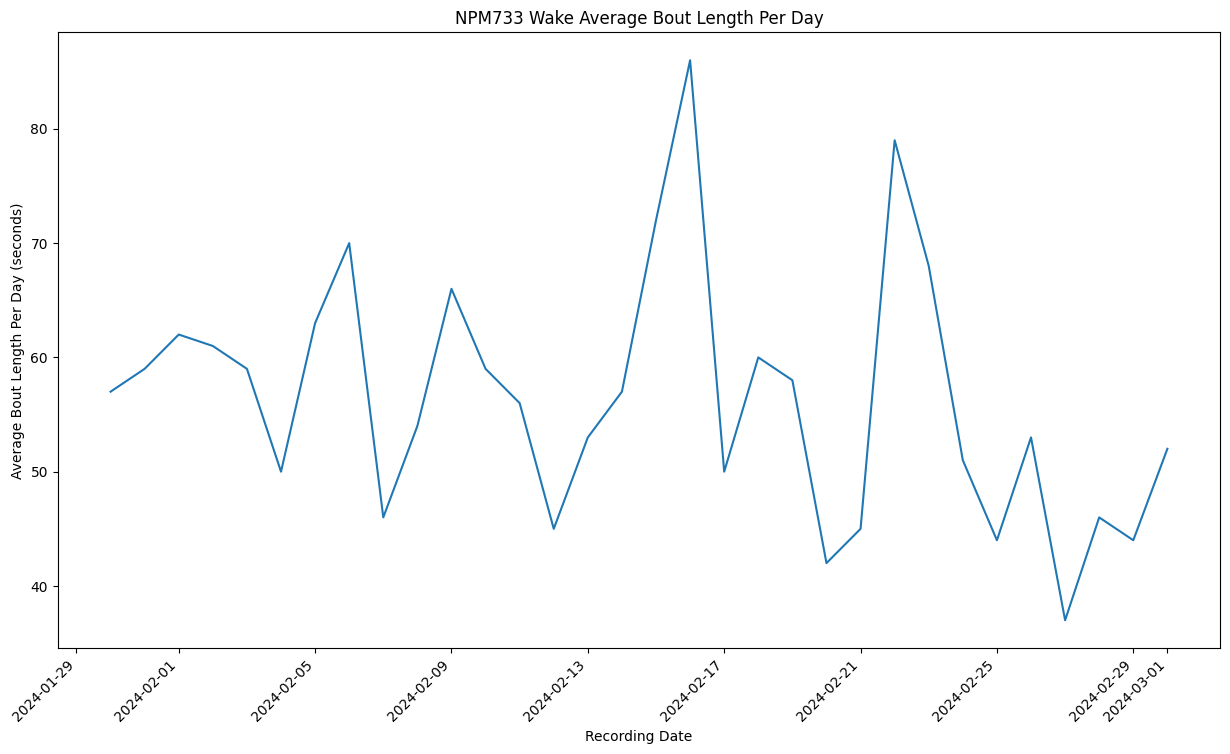

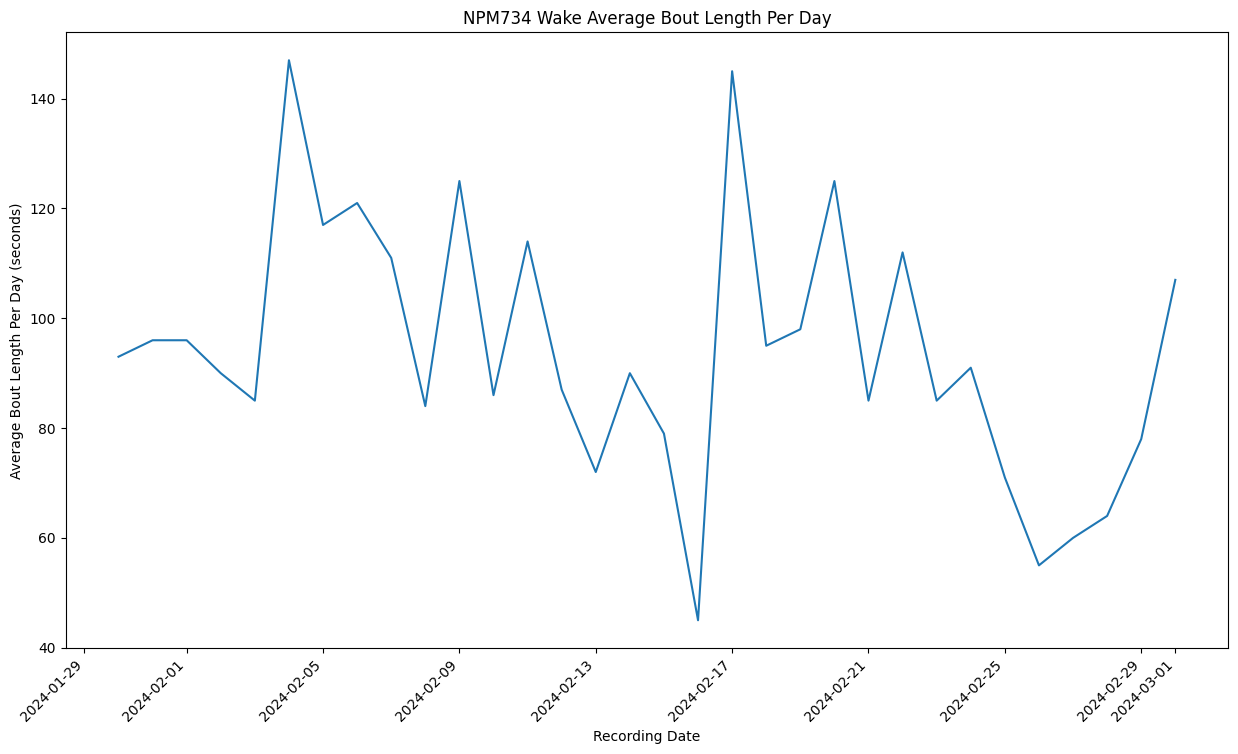

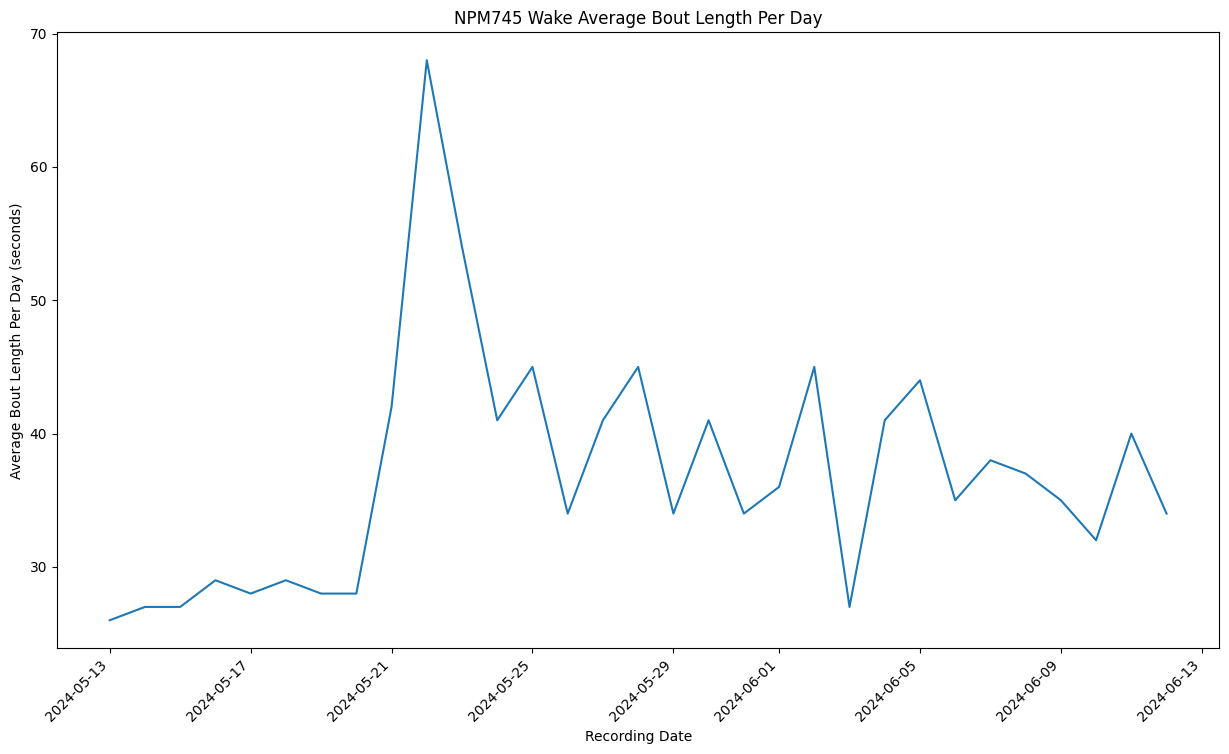

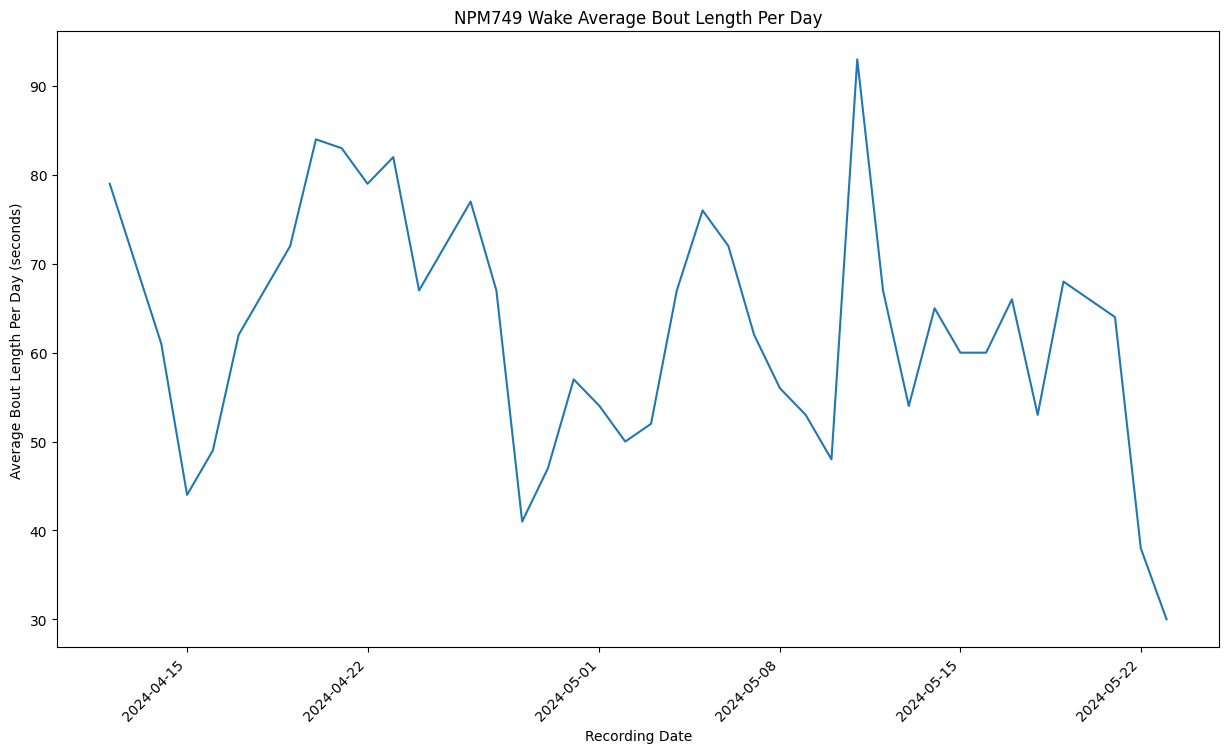

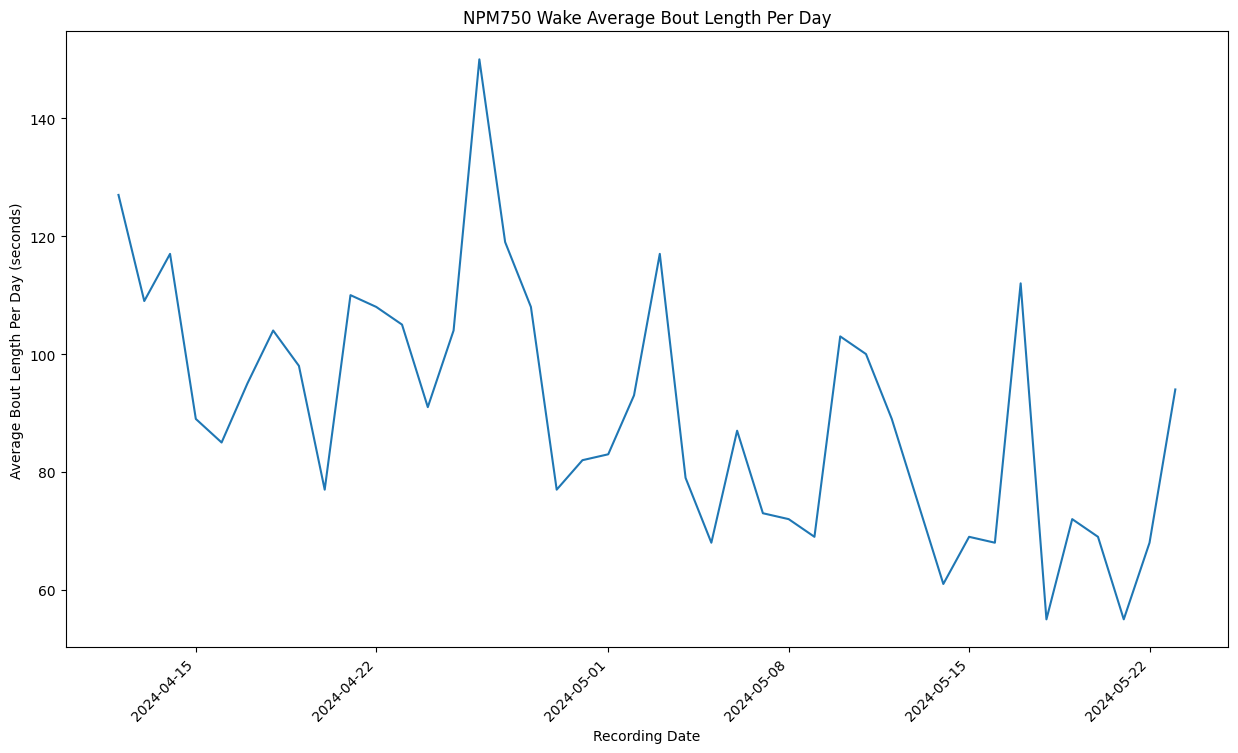

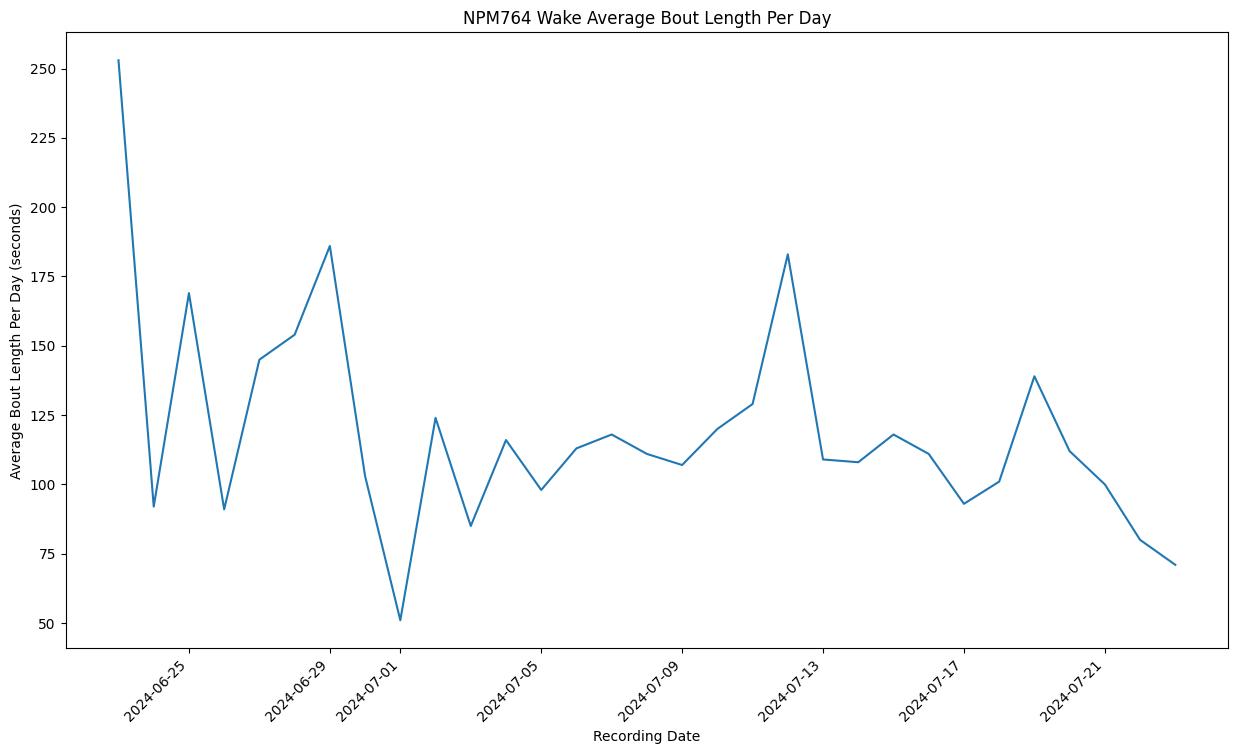

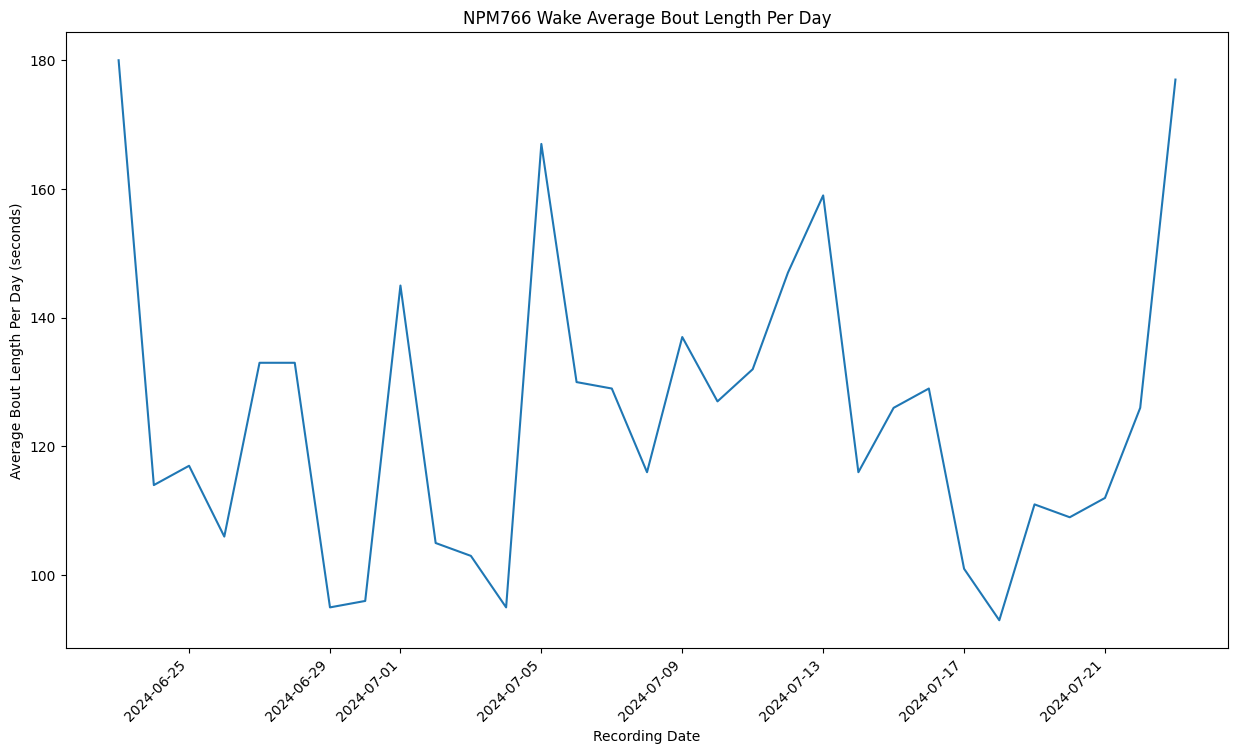

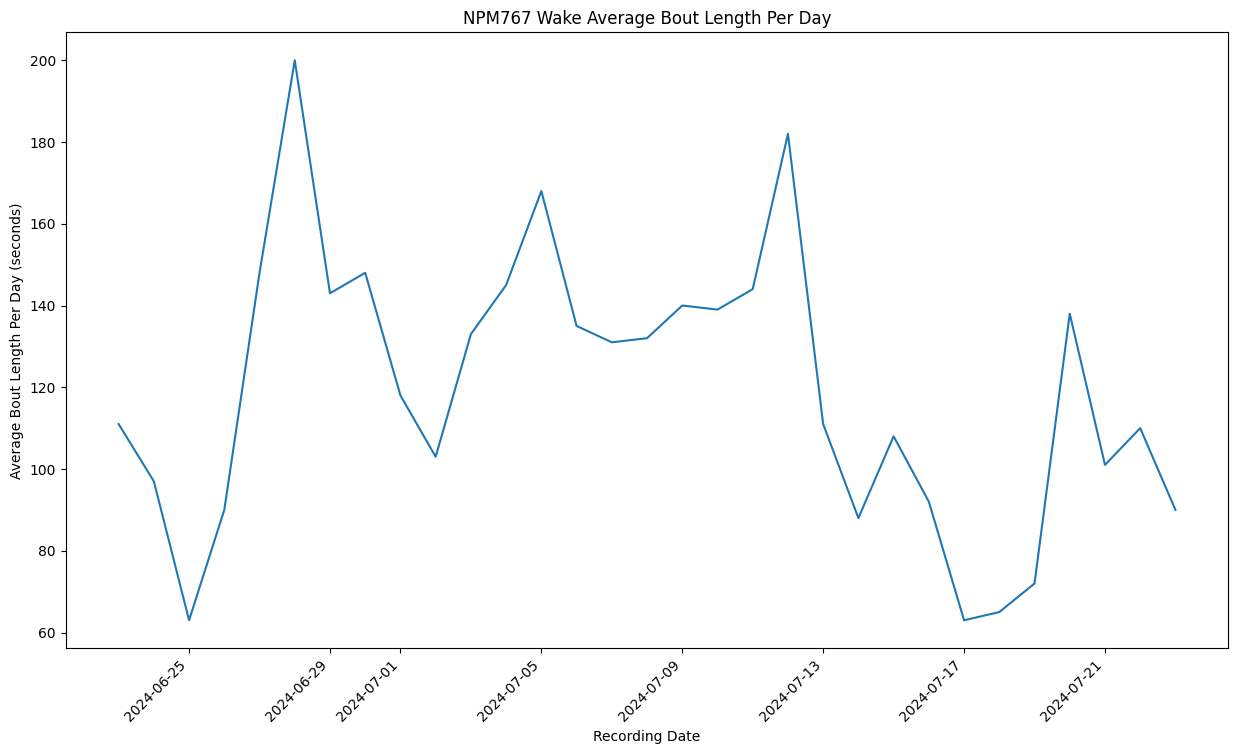

In [17]:


states=['Wake','NREM','REM','Seizure','Post Ictal']
bouts, by_bout_id = sleep.compute_bouts(df)

for animal in df['subject'][df['condition']=='Pilo'].unique():

    for score in range(1):
        fig, ax = plt.subplots(figsize=(15, 8))

        grouped_score=by_bout_id.groupby('scores').get_group(score).groupby('subject').get_group(animal)
        output=sleep.average_bout_length_by_day(grouped_score)
        # print(output['datetime'],output['datetime'].dt.date,output['average_bout_length'])
        plt.plot(output['datetime'].dt.date,output['average_bout_length']/1e9)
        plt.title(f'{animal} {states[score]} Average Bout Length Per Day')
        
        # legend_elements = [Line2D([0], [0], color='orange', lw=4, label='Baseline'),
        #                    Line2D([0], [0], color='pink', lw=4, label='Epileptic Baseline'),
        #                    Line2D([0], [0], color='purple', lw=4, label='Treatment'),
        #                    Line2D([0], [0], color='green', lw=4, label='Behavior'),
        #                    Line2D([0], [0], color='navy', lw=4, label='Washout'),
        #                   Line2D([0], [0], color='black', lw=4, label='Death')
        #                   ]

        # ax.legend(handles=legend_elements)
        plt.xticks(rotation=45, ha="right")
        # if animal=='NPM739':
        #     plt.axvline(strdtYMD('2024-03-11'),c='orange')
        #     plt.axvline(strdtYMD('2024-03-18'),c='pink')
        #     plt.axvline(strdtYMD('2024-04-11'),c='purple')
        #     plt.axvline(strdtYMD('2024-04-29'),c='green')
        #     plt.axvline(strdtYMD('2024-05-01'),c='navy')
        #     plt.axvline(strdtYMD('2024-05-08'),c='purple')
        #     plt.axvline(strdtYMD('2024-05-18'),c='black')
        # if animal=='NPM758':
        #     plt.axvline(strdtYMD('2024-06-11'),c='orange')
        #     plt.axvline(strdtYMD('2024-06-19'),c='pink')
        #     plt.axvline(strdtYMD('2024-06-25'),c='purple')
        #     plt.axvline(strdtYMD('2024-07-15'),c='green')
        #     plt.axvline(strdtYMD('2024-07-17'),c='navy')
        #     plt.axvline(strdtYMD('2024-07-21'),c='purple')
        plt.xlabel(f'Recording Date')
        plt.ylabel(f'Average Bout Length Per Day (seconds)')

        # plt.savefig(f'Y:/SMRXConversion/Export/{animal} {states[score]} Average Bout Length Per Day Plot.png')
        plt.show()

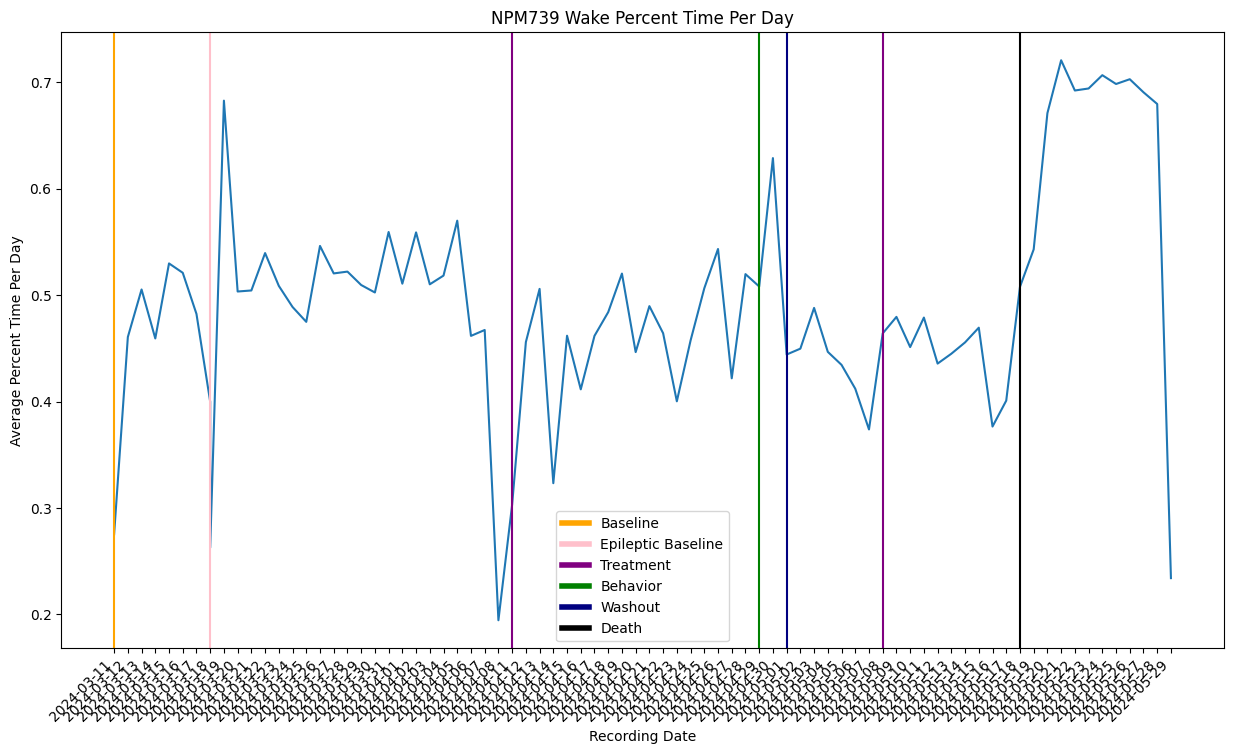

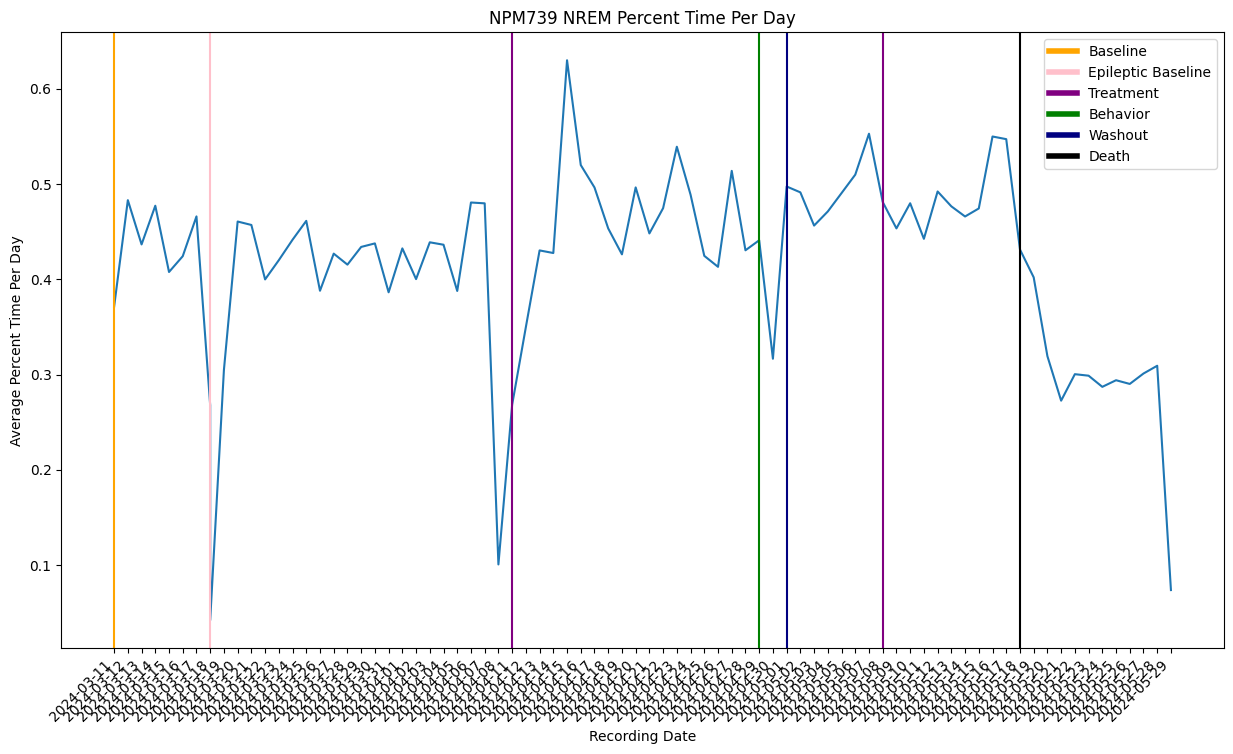

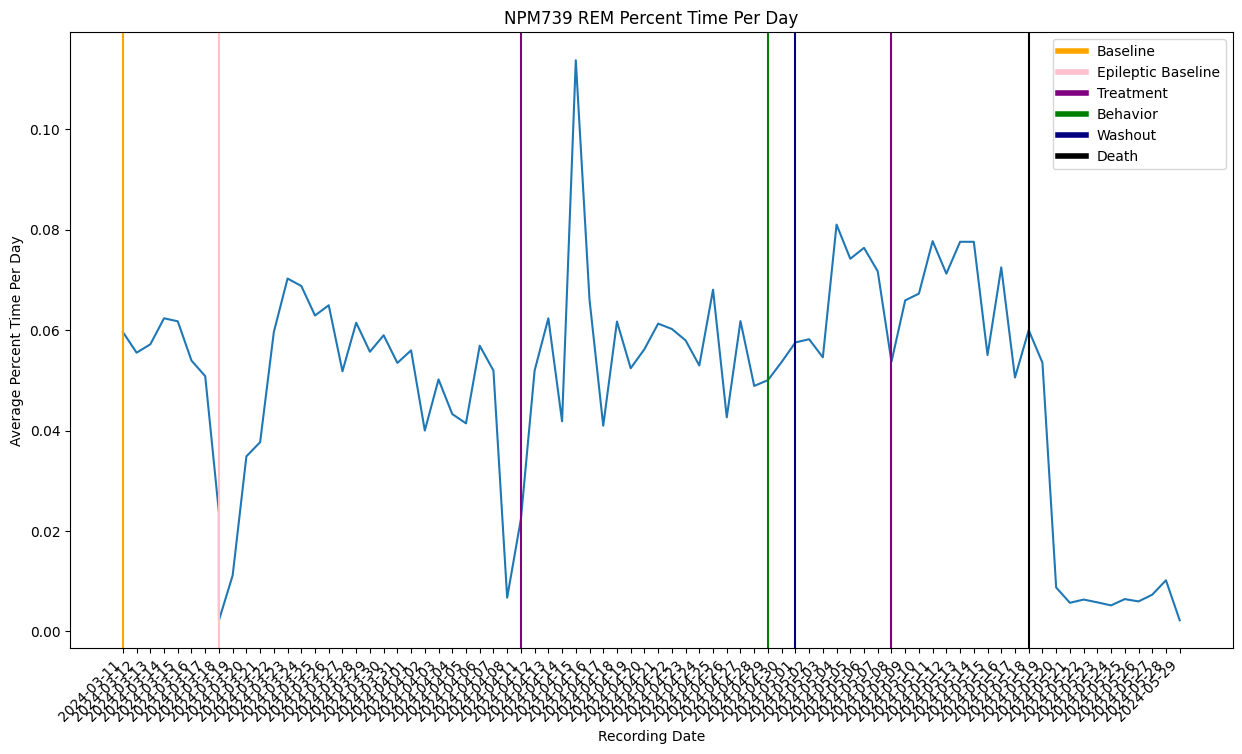

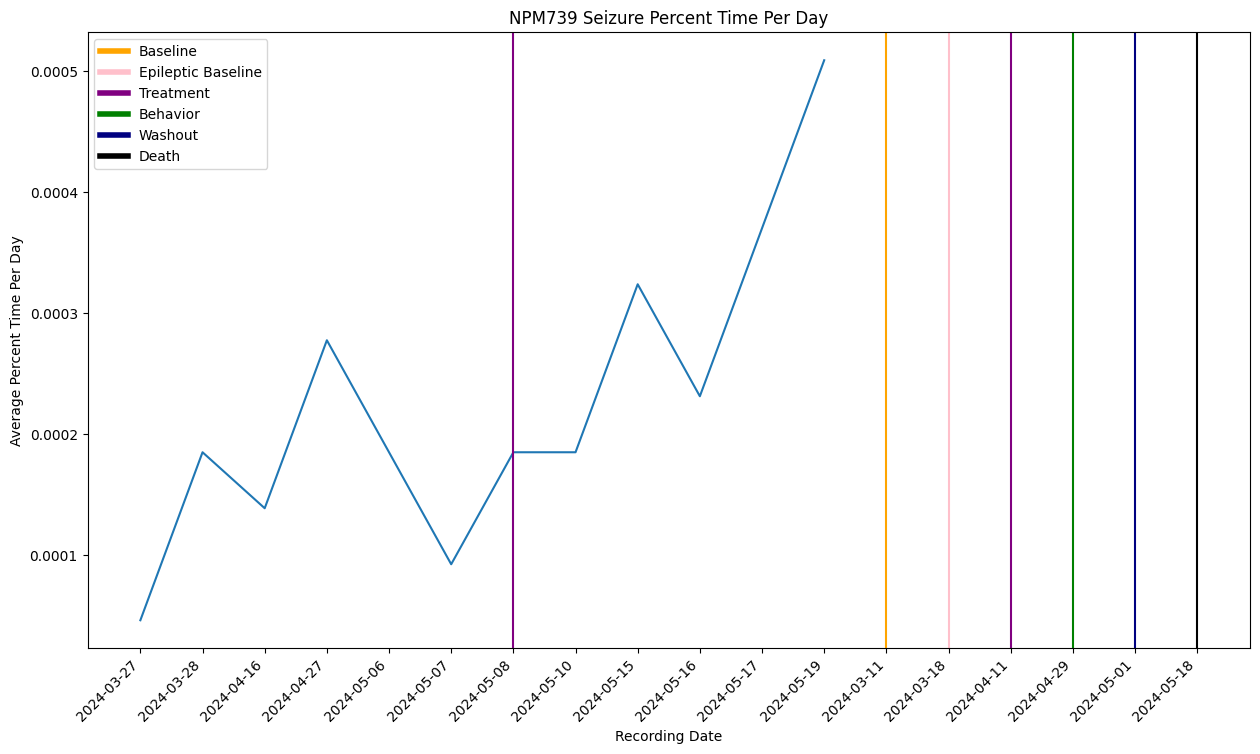

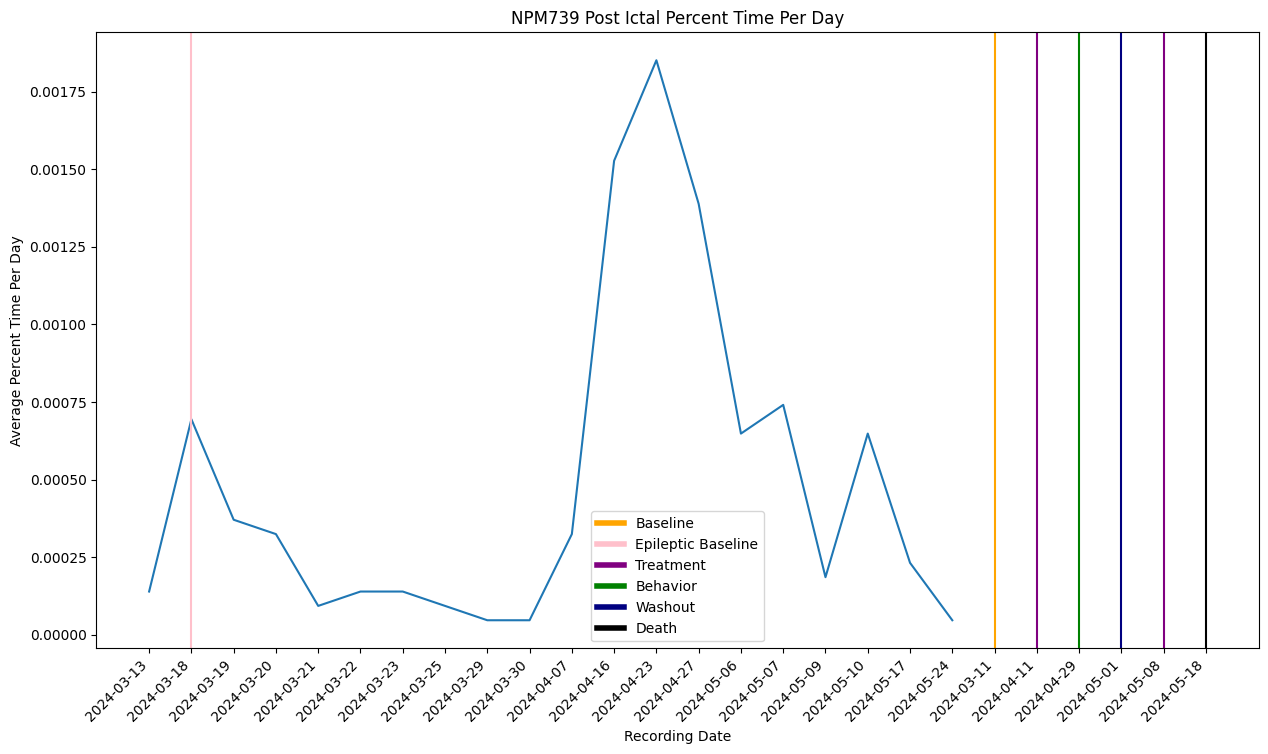

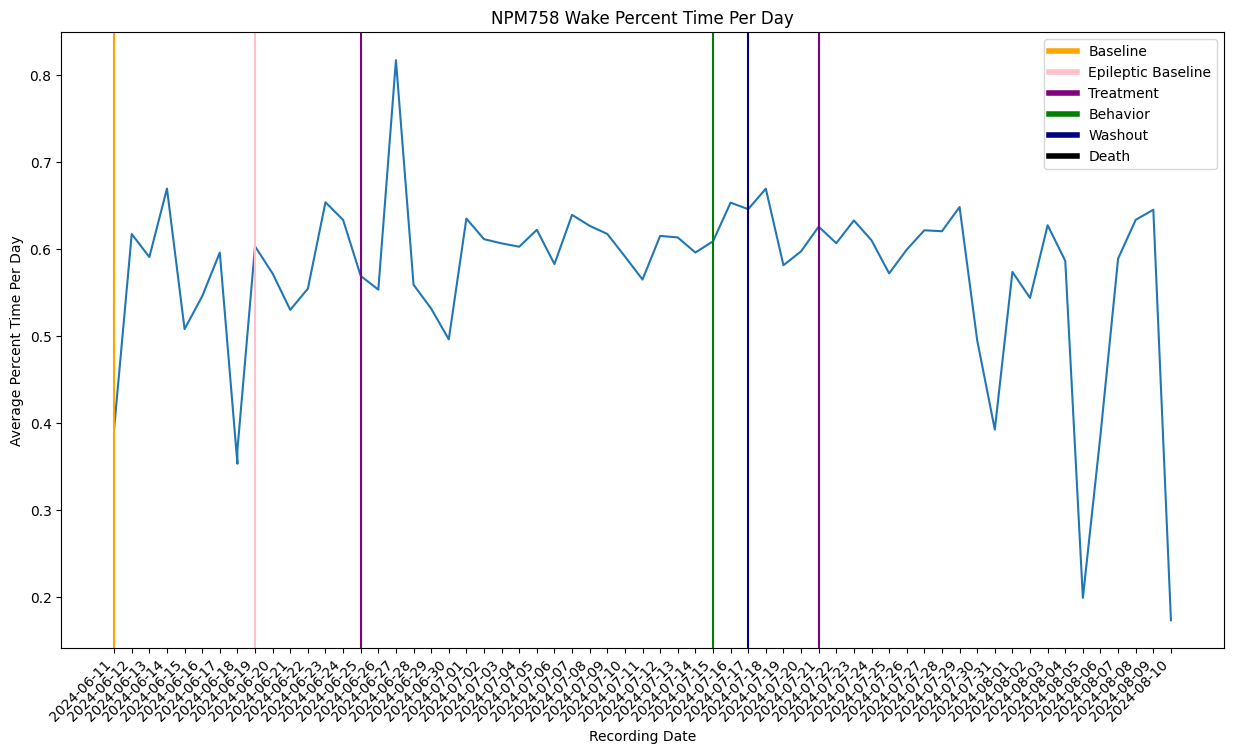

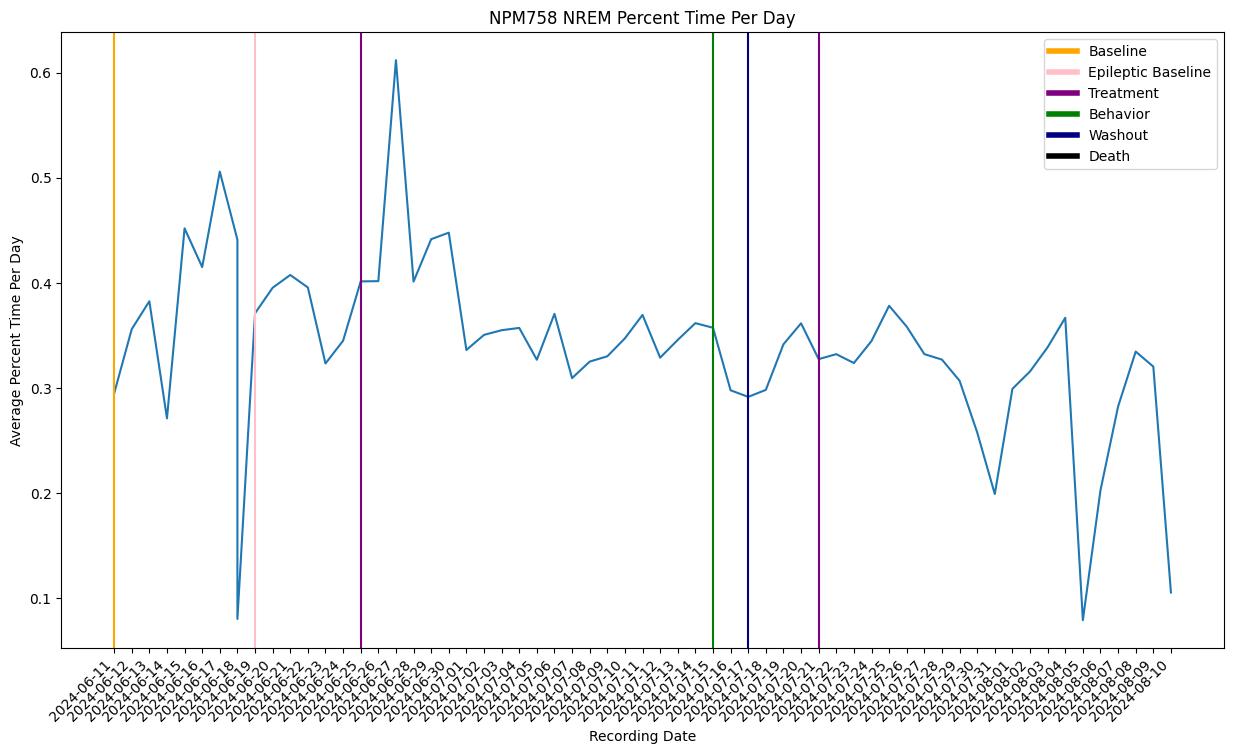

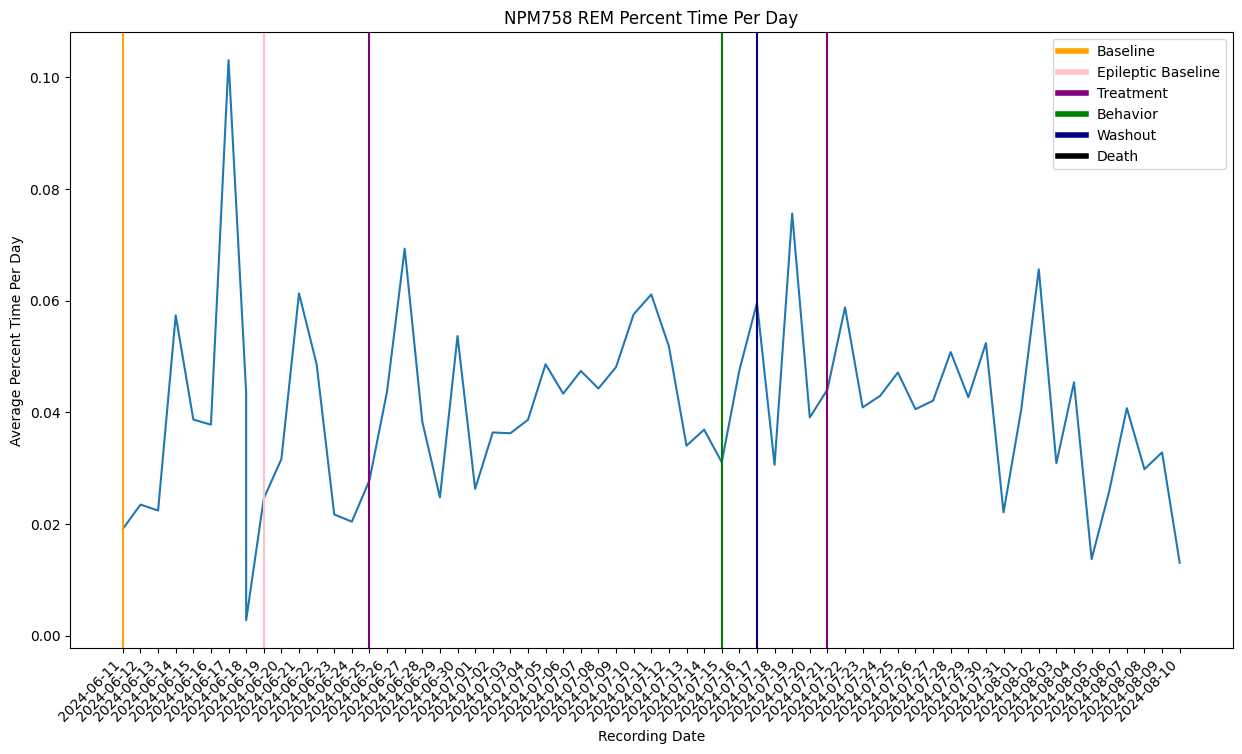

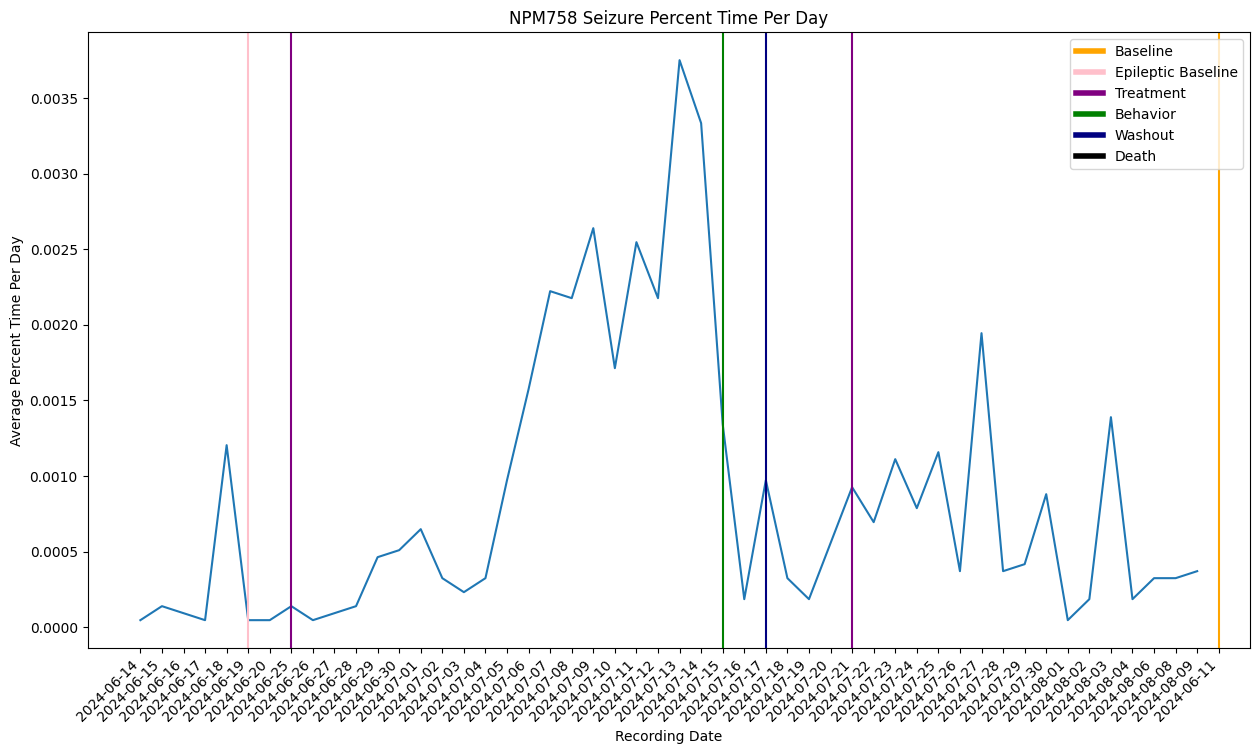

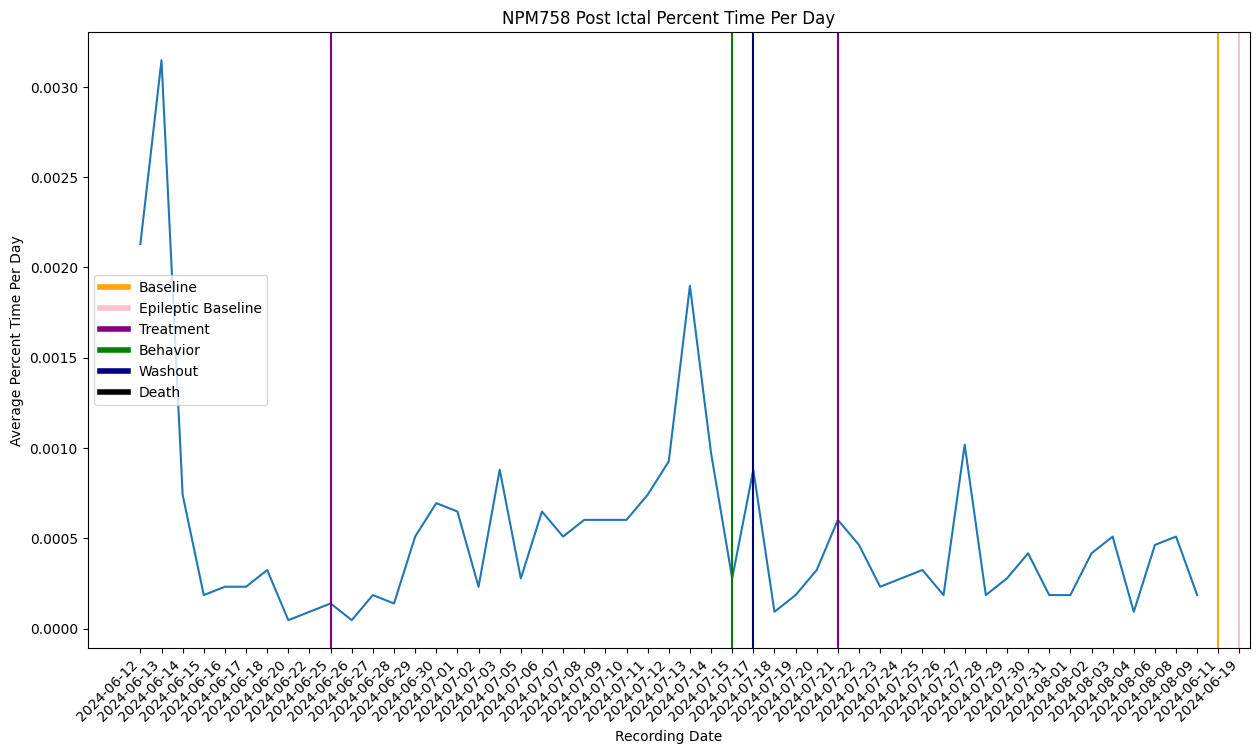

In [178]:
def strdtYMD(input):
    return datetime.strptime(input,'%Y-%m-%d')
# def strdtYMDH(input):
#     return datetime.strptime(input,'%Y-%m-%d-%H')

import matplotlib.pyplot as plt

for animal in ['NPM739', 'NPM758']:

    for score in range(5):
        fig, ax = plt.subplots(figsize=(15, 8))
        output=state_by_day(df).groupby('scores').get_group(score).groupby('subject').get_group(animal)
        output.head(100)
        # output=output[(output['datetime'].dt.hour==10)]

        plt.plot(output['datetime'].dt.strftime('%Y-%m-%d'),output['seconds_per_day'].dt.total_seconds()/(24*3600))
        timescale='Day'
        plt.title(f'{animal} {states[score]} Percent Time Per {timescale}')
        
        legend_elements = [Line2D([0], [0], color='orange', lw=4, label='Baseline'),
                           Line2D([0], [0], color='pink', lw=4, label='Epileptic Baseline'),
                           Line2D([0], [0], color='purple', lw=4, label='Treatment'),
                           Line2D([0], [0], color='green', lw=4, label='Behavior'),
                           Line2D([0], [0], color='navy', lw=4, label='Washout'),
                           Line2D([0], [0], color='black', lw=4, label='Death')
                           ]

        ax.legend(handles=legend_elements)
        plt.xticks(rotation=45, ha="right")
        # if animal=='NPM739':
        #     plt.axvline('2024-03-11-10',c='orange')
        #     plt.axvline('2024-03-18-10',c='pink')
        #     plt.axvline('2024-04-11-10',c='purple')
        #     plt.axvline('2024-04-29-10',c='green')
        #     plt.axvline('2024-05-01-10',c='navy')
        #     plt.axvline('2024-05-08-10',c='purple')
        #     plt.axvline('2024-05-18-10',c='black')
        # if animal=='NPM758':
        #     plt.axvline('2024-06-11-10',c='orange')
        #     plt.axvline('2024-06-19-10',c='pink')
        #     plt.axvline('2024-06-25-10',c='purple')
        #     plt.axvline('2024-07-15-10',c='green')
        #     plt.axvline('2024-07-17-10',c='navy')
        #     plt.axvline('2024-07-21-10',c='purple')

        if animal=='NPM739':
            plt.axvline('2024-03-11',c='orange')
            plt.axvline('2024-03-18',c='pink')
            plt.axvline('2024-04-11',c='purple')
            plt.axvline('2024-04-29',c='green')
            plt.axvline('2024-05-01',c='navy')
            plt.axvline('2024-05-08',c='purple')
            plt.axvline('2024-05-18',c='black')
        if animal=='NPM758':
            plt.axvline('2024-06-11',c='orange')
            plt.axvline('2024-06-19',c='pink')
            plt.axvline('2024-06-25',c='purple')
            plt.axvline('2024-07-15',c='green')
            plt.axvline('2024-07-17',c='navy')
            plt.axvline('2024-07-21',c='purple')
        plt.xlabel(f'Recording Date')
        plt.ylabel(f'Average Percent Time Per {timescale}')

        plt.savefig(f'Y:/SMRXConversion/Export/{animal} {states[score]} Average Percent Time Per {timescale} Plot.png')
        plt.show()